In [71]:
import requests
import pandas as pd
import xmltodict
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import networkx as nx

In [77]:
class ApiGetter():
    """
        Classe para fazer requests em APIs e tratar os erros de conexão
    """
    @staticmethod
    def get(url : str):
        try:
            response = requests.get(url)
            return response
        except requests.exceptions.RequestException as e:
            print(e)
            return None

class ApiXmlParser():
    """
        Classe para parsear xml de resposta de APIs, pois algumas respostas da API do senado vem em xml e outras json
    """
    @staticmethod
    def parse(xml : bytes, encoding : str):
        if xml is None:
            return None
        try:
            xml_decoded = xml.decode(encoding)
            return xmltodict.parse(xml_decoded)
        except Exception as e:
            print(e)
            return None

class ApiJsonParser():
    """
        Classe para parsear json de resposta de APIs, pois algumas respostas da API do senado vem em xml e outras json
    """
    @staticmethod
    def parse(json : bytes):
        if json is None:
            return None
        try:
            json_decoded = json.decode('utf-8')
            return json_decoded.json()
        except Exception as e:
            print(e)
            return None
    
class AutorMateriaAnalytics():
    """
        Classe para fazer análises sobre os autores de matérias legislativas
    """

    def __init__(self):
        self.api_response = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/autor/lista/atual")
        self.parsed_response = ApiXmlParser.parse(self.api_response.content, 'ISO-8859-1')
        self.dataframe_autores()
    
    def dataframe_autores(self):
        if self.parsed_response is None:
            return None
        try:
            autores = self.parsed_response['ListaAutores']['Autores']['Autor']
            df_autores = pd.DataFrame(autores, columns=['CodigoParlamentar', 'FormaTratamento', 'NomeParlamentar', 'QuantidadeMaterias'])
            df_autores['QuantidadeMaterias'] = pd.to_numeric(df_autores['QuantidadeMaterias'], errors='coerce')
            self.df_autores = df_autores
        except Exception as e:
            print(e)
            return None
    
    def autores_histogram(self, autores_types_list : list):
        """
            Plotar um histrograma dado uma lista de tipos dos autores de materias legislativas eg. ['deputado', 'senador', 'congressista']
        """
        self.dataframe_autores()
        for autor_type in autores_types_list:
            current_df = None
            if autor_type == 'Congressistas':
                current_df = self.df_autores
            else:
                current_df = self.df_autores[self.df_autores['FormaTratamento'] == autor_type]
            y, x = np.histogram(current_df['QuantidadeMaterias'], bins=20)
            percentages = y / y.sum() * 100
            plt.figure(figsize=(20, 6))
            plt.text(0.95, 0.95, f'Total {autor_type.capitalize()}: {len(current_df)}', 
                    horizontalalignment='right', verticalalignment='top', 
                    transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
            plt.yticks(range(0, 500, 40))
            plt.xticks(range(0, 600, 20))
            current_df['QuantidadeMaterias'].plot(kind='hist', bins=20, edgecolor='black')
            for i in range(len(x) - 1):
                if percentages[i] > 0:
                    plt.text(x[i] + (x[i + 1] - x[i]) / 2, y[i], f'{percentages[i]:.1f}%', ha='center', va='bottom')
            plt.title(f'Histograma do número de materias com relação à quantidade de {autor_type.capitalize()}')
            plt.xlabel('Quantidade de Materias Legislativas')
            plt.ylabel(f'Número de {autor_type.capitalize()}')
            plt.grid(True)
            plt.show()

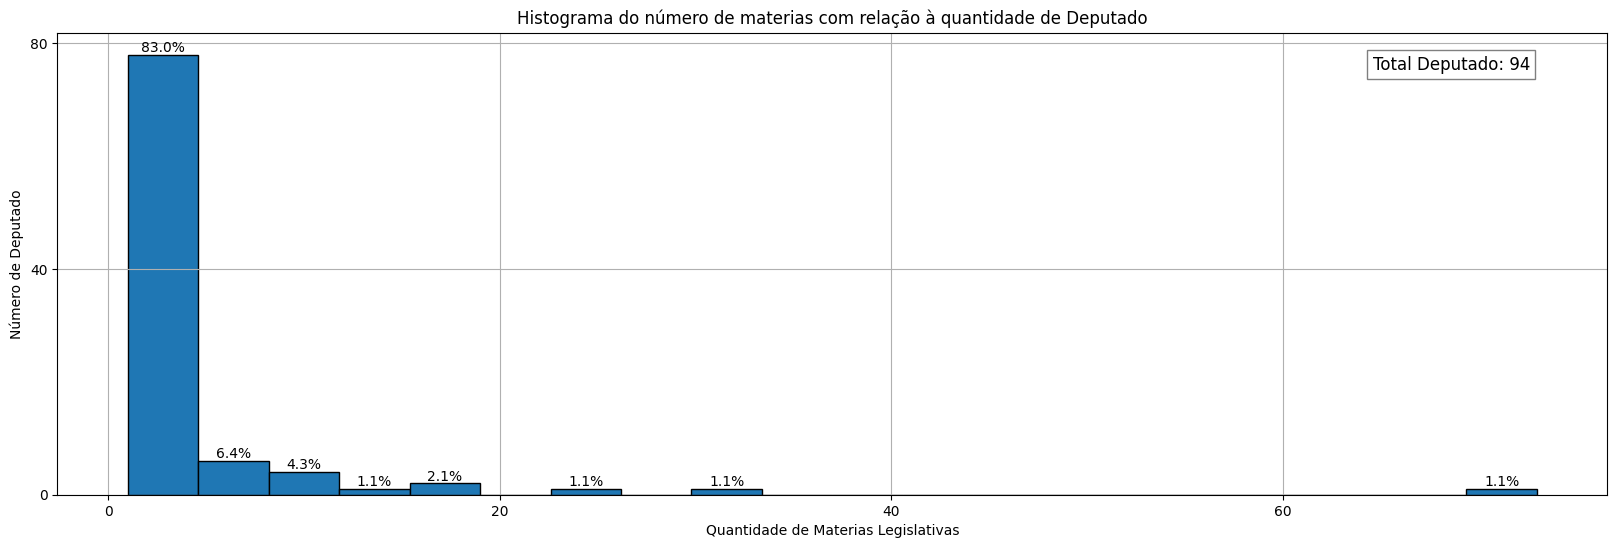

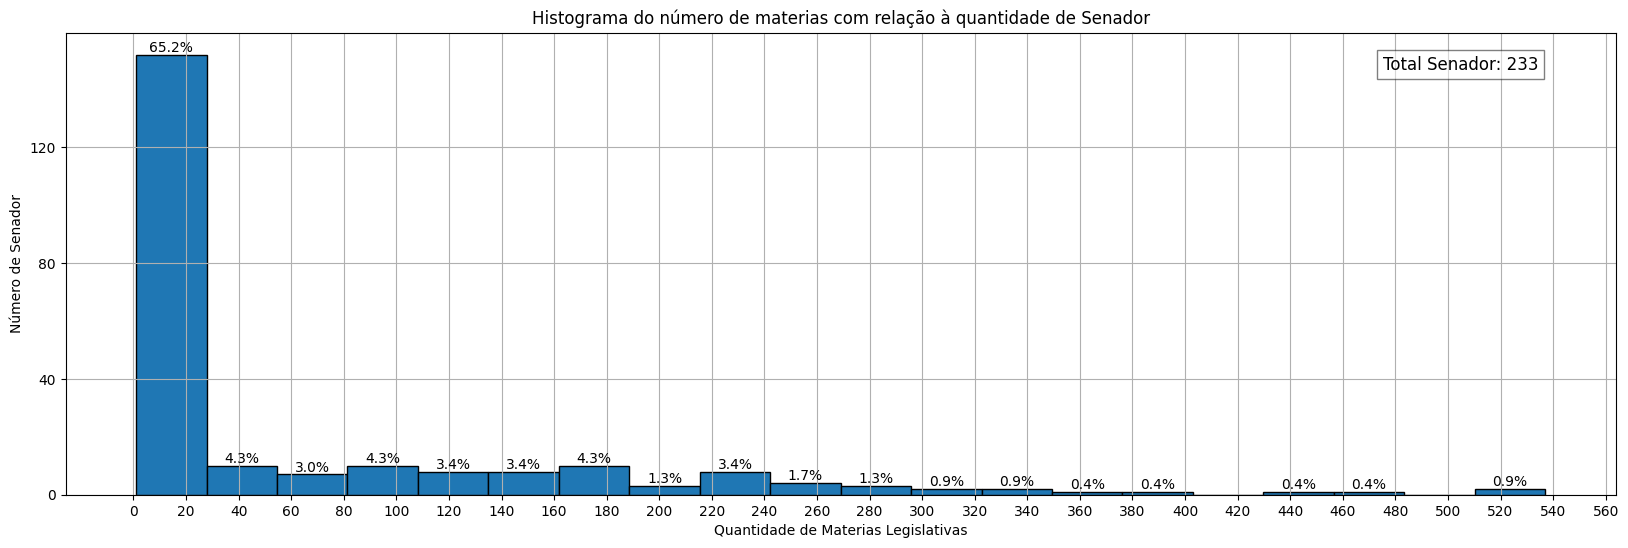

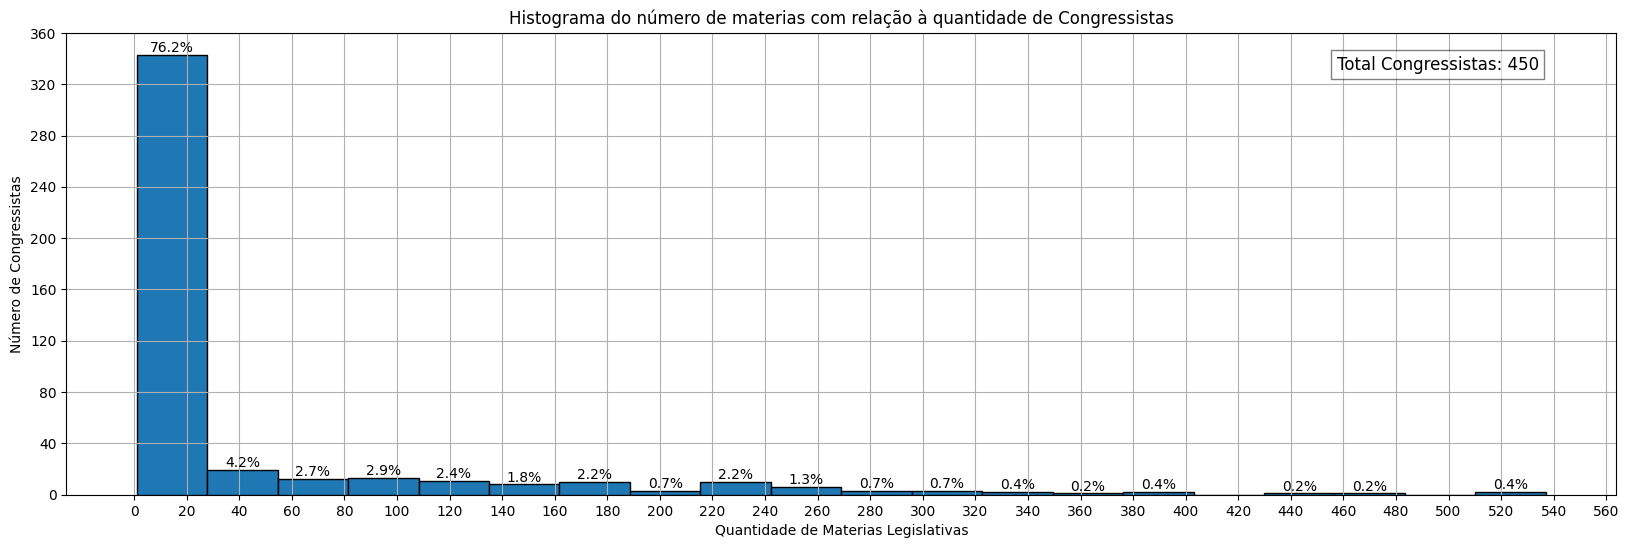

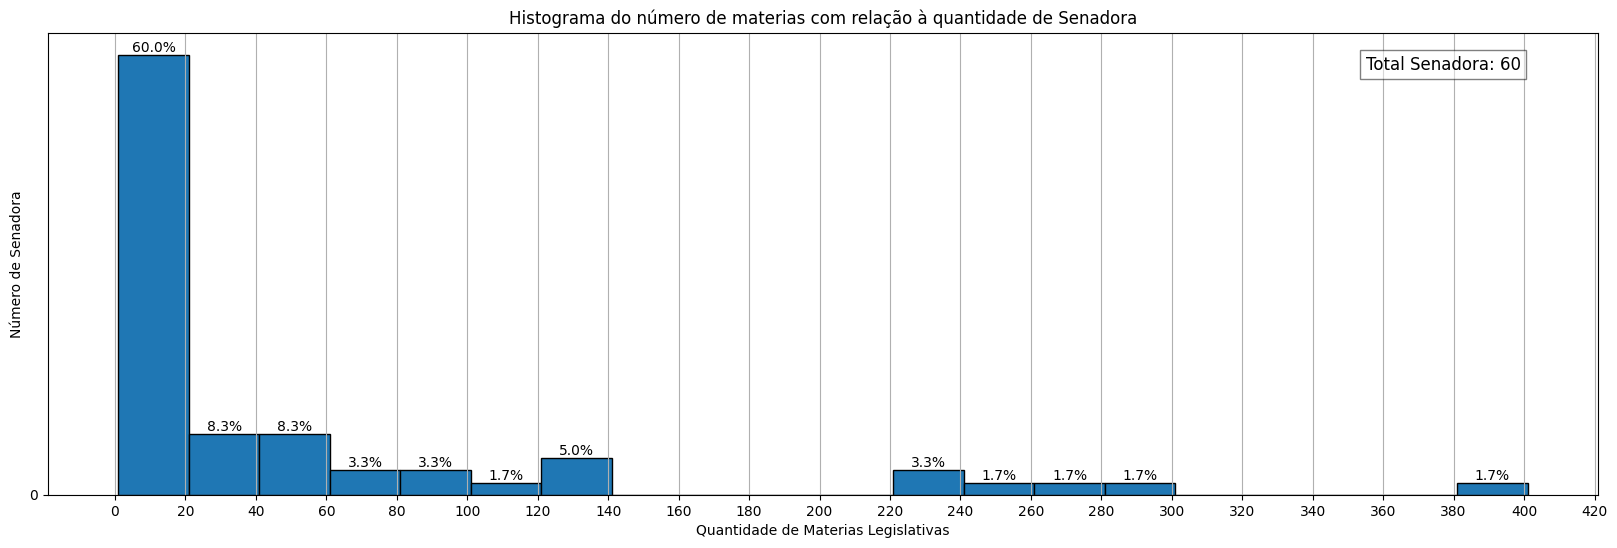

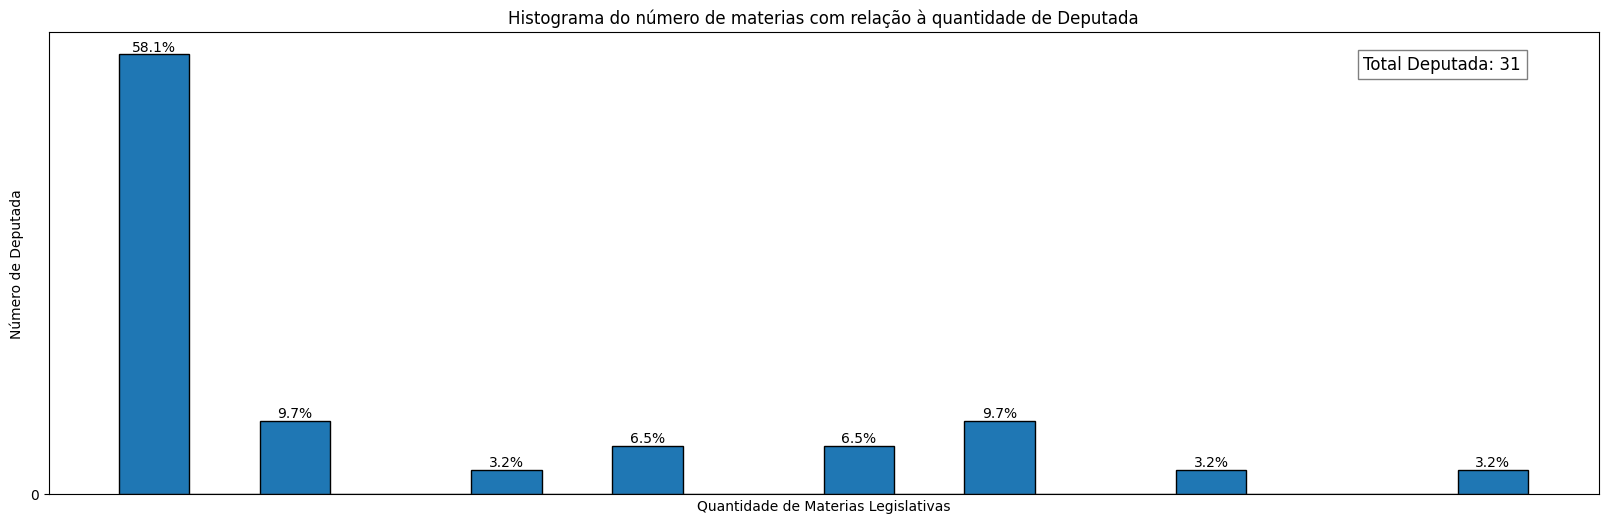

In [78]:
autor_analytics = AutorMateriaAnalytics()
autor_analytics.autores_histogram(['Deputado', 'Senador', 'Congressistas', 'Senadora', 'Deputada'])

In [79]:
class SenadoresAnalytics():
    """
        Classe para fazer análises sobre todos os senadores, afastados ou atuais e disponibilizar os dataframes.
    """
    def __init__(self):
        self.api_response_atuais = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/senador/lista/atual")
        self.api_response_afastados = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/senador/lista/afastados")
        self.parsed_response_atuais = ApiXmlParser.parse(self.api_response_atuais.content, 'utf-8')
        self.parsed_response_afastados = ApiXmlParser.parse(self.api_response_afastados.content, 'utf-8')
        self.df_senadores = None
        self.df_senadores_atuais = None
    
    def merge_senadores(self):
        """
            Juntar os senadores atuais e afastados em um único dataframe
        """
        if self.parsed_response_atuais is None or self.parsed_response_afastados is None:
            return None
        try:
            senadores = []
            for senador_atual in self.parsed_response_atuais['ListaParlamentarEmExercicio']['Parlamentares']['Parlamentar']:
                senadores.append({
                    'CodigoParlamentar': senador_atual['IdentificacaoParlamentar']['CodigoParlamentar'],
                    'FormaTratamento': senador_atual['IdentificacaoParlamentar']['FormaTratamento'],
                    'NomeParlamentar': senador_atual['IdentificacaoParlamentar']['NomeParlamentar'],
                    'SiglaPartido': senador_atual['IdentificacaoParlamentar']['SiglaPartidoParlamentar'],
                    'Mandato': '1' if date.fromisoformat(senador_atual['Mandato']['SegundaLegislaturaDoMandato']['DataInicio']) < date.today() else '2',
                    'Afastamento': '0'
                })
            self.df_senadores_atuais = pd.DataFrame(senadores, columns=['CodigoParlamentar', 'FormaTratamento', 'NomeParlamentar', 'SiglaPartido', 'Mandato', 'Afastamento'])
            for senador_afastado in self.parsed_response_afastados['AfastamentoAtual']['Parlamentares']['Parlamentar']:
                senadores.append({
                    'CodigoParlamentar': senador_afastado['IdentificacaoParlamentar']['CodigoParlamentar'],
                    'FormaTratamento': senador_afastado['IdentificacaoParlamentar']['FormaTratamento'],
                    'NomeParlamentar': senador_afastado['IdentificacaoParlamentar']['NomeParlamentar'],
                    'SiglaPartido': senador_afastado['IdentificacaoParlamentar'].get('SiglaPartidoParlamentar', None),
                    'Mandato': '1' if date.fromisoformat(senador_afastado['Mandato']['SegundaLegislaturaDoMandato']['DataInicio']) < date.today() else '2',
                    'Afastamento': '1'
                })
            df_senadores = pd.DataFrame(senadores, columns=['CodigoParlamentar', 'FormaTratamento', 'NomeParlamentar', 'SiglaPartido', 'Mandato', 'Afastamento'])
            self.df_senadores = df_senadores
        except Exception as e:
            print(e)
            return None
    
    def histograma_senadores_partido(self):
        """
            Plotar um histograma com a quantidade de senadores por partido
        """
        self.merge_senadores()
        if self.df_senadores is None:
            return None
        plt.figure(figsize=(20, 6))
        self.df_senadores['SiglaPartido'].value_counts().plot(kind='bar', edgecolor='black')
        plt.title('Histograma da quantidade de senadores por partido')
        plt.xlabel('Sigla do Partido')
        plt.ylabel('Número de Senadores')
        plt.grid(True)
        plt.show()
    
    def join_senadores_materias(self):
        """
            Juntar os senadores com a quantidade de materias legislativas que eles são autores
        """
        autor_analytics = AutorMateriaAnalytics()
        df_autores_materias = autor_analytics.df_autores
        df_senadores_joined = self.df_senadores.set_index('CodigoParlamentar').join(df_autores_materias.set_index('CodigoParlamentar'), on='CodigoParlamentar', how='inner', lsuffix='_senadores', rsuffix='_autores')
        df_senadores_joined = df_senadores_joined.dropna(subset=['QuantidadeMaterias'])
        return df_senadores_joined
    
    def histograma_materias_por_partido(self):
        """
            Plotar um histograma com a quantidade de materias legislativas por partido
        """
        df_senadores_joined = self.join_senadores_materias()
        df_senadores_joined.groupby('SiglaPartido')['QuantidadeMaterias'].sum().plot(kind='bar')
        plt.title('Quantidade de materias por partido')
        plt.xlabel('Partido')
        plt.ylabel('Quantidade de materias')
        plt.grid(True)
        plt.show()      
        

In [80]:
senadores_analytics = SenadoresAnalytics()


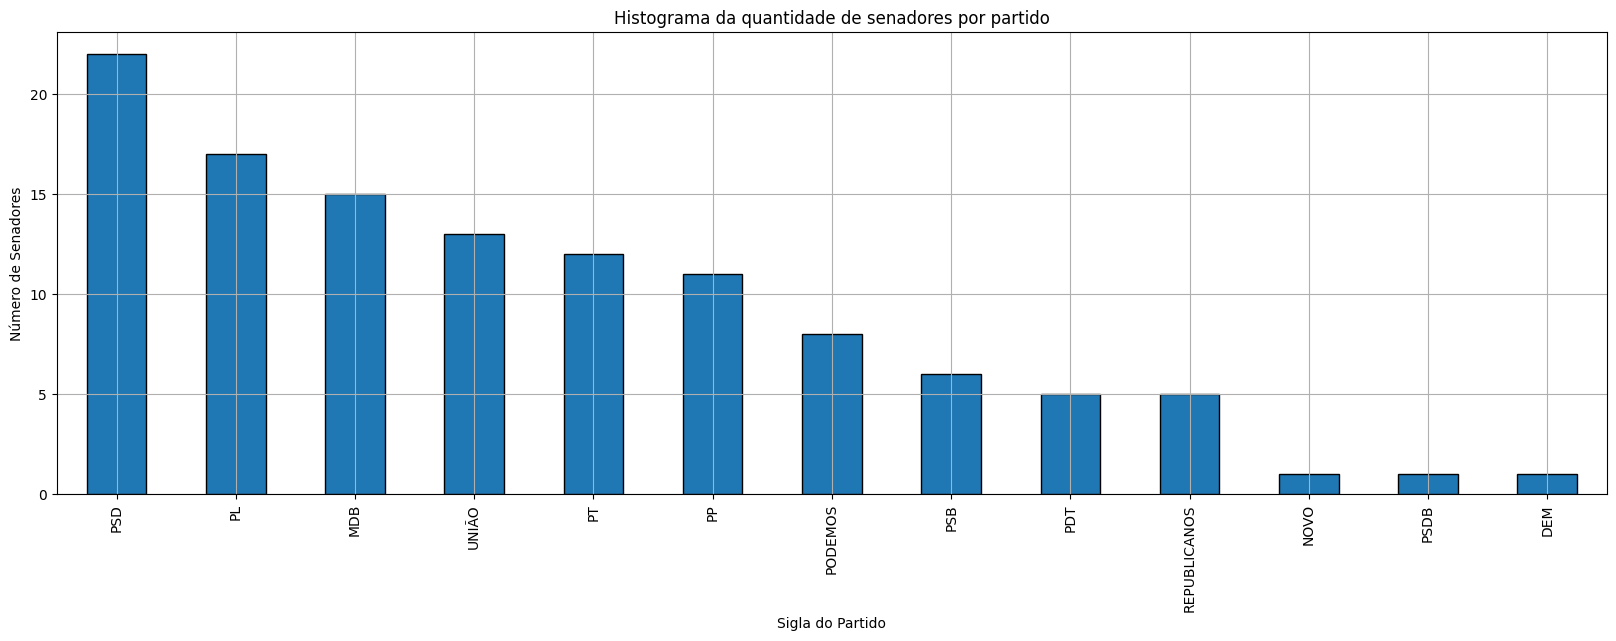

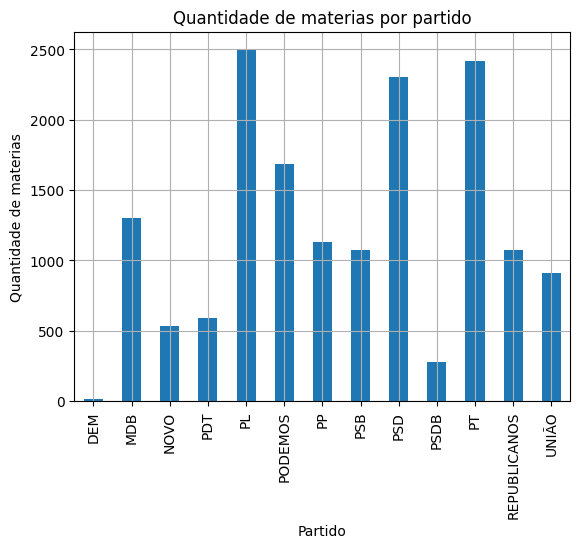

In [81]:
senadores_analytics.histograma_senadores_partido()
senadores_analytics.histograma_materias_por_partido()

In [85]:
class AssuntoMateriaAnalytics():
    """
        Classe para fazer análises sobre os assuntos das matérias legislativas
        
    """
    
    def __init__(self):
        self.api_response = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/materia/assuntos")
        self.parsed_response = ApiXmlParser.parse(self.api_response.content, 'utf-8')
        self.dataframe_assuntos()

    def dataframe_assuntos(self):
        if self.parsed_response is None:
            return None
        try:
            assuntos = self.parsed_response['ListaAssuntos']['Assuntos']['Assunto']
            df_assuntos = pd.DataFrame(assuntos, columns=['Codigo', 'AssuntoGeral', 'AssuntoEspecifico'])
            self.df_assuntos = df_assuntos
        except Exception as e:
            print(e)
            return None
    
    def histograma_assuntos(self):
        """
            Plotar um histograma com a quantidade de materias legislativas por assunto
        """ 
        self.df_assuntos['AssuntoGeral'].value_counts().plot(kind='bar', figsize=(20, 6), edgecolor='black')
        plt.title('Quantidade de assuntos por assunto geral')
        plt.xlabel('Assunto Geral')
        plt.ylabel('Quantidade de Assuntos')
        plt.grid(True)
        plt.show()
    
                                                                

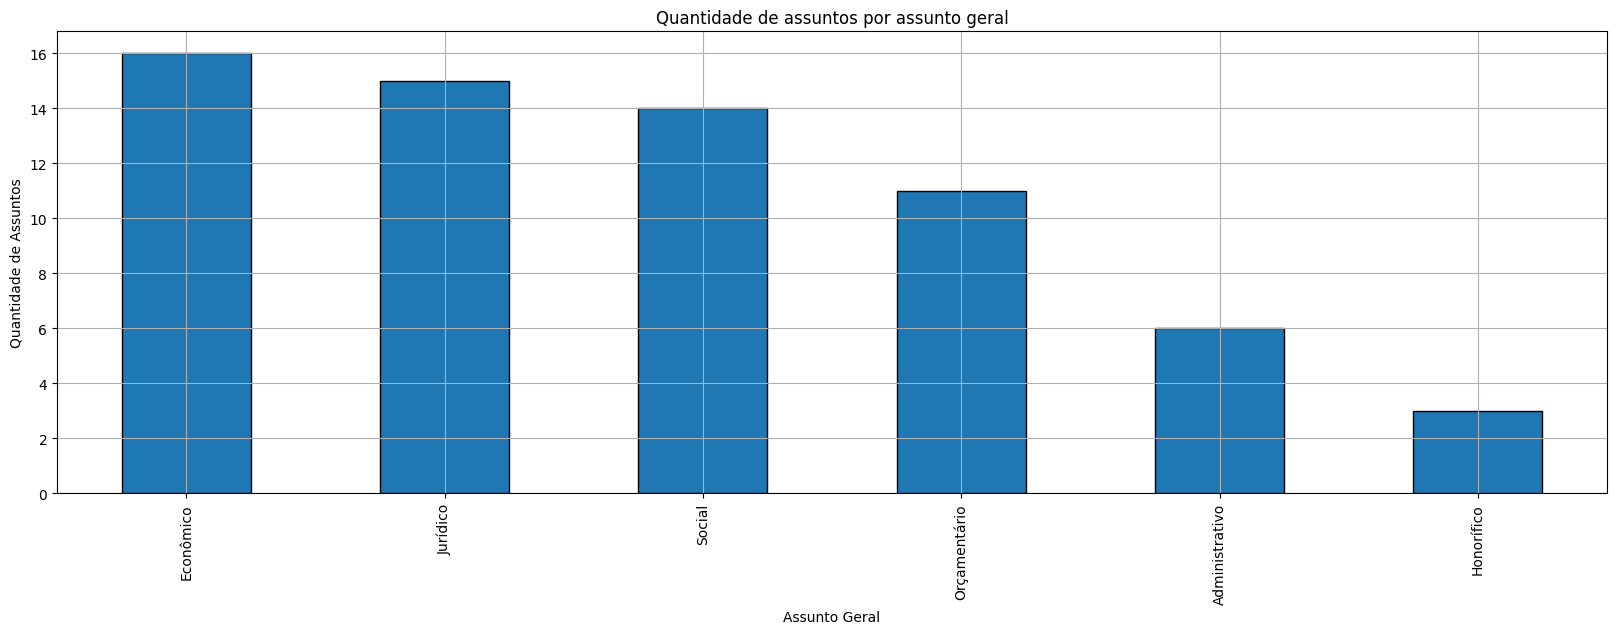

In [86]:
assunto_materia_analytics = AssuntoMateriaAnalytics()
assunto_materia_analytics.histograma_assuntos()

In [ ]:
class BlocosPoliticosAnalytics():
    """
        Classe para fazer análises sobre os blocos políticos
    """
    
    def __init__(self):
        self.api_response = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/blocos")
        self.parsed_response = ApiXmlParser.parse(self.api_response.content, 'utf-8')
        self.blocos = self.parsed_response['ListaBlocoParlamentar']['Blocos']['Bloco']

In [63]:
api_response_blocos = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/blocoParlamentar/lista")
parsed_response_blocos = ApiXmlParser.parse(api_response_blocos.content, 'utf-8')
blocos = parsed_response_blocos['ListaBlocoParlamentar']['Blocos']['Bloco']
blocos


[{'CodigoBloco': '346',
  'NomeBloco': 'Bloco Parlamentar Aliança',
  'NomeApelido': 'BLALIANÇA',
  'DataCriacao': '2023-03-20',
  'Membros': {'Membro': [{'Partido': {'CodigoPartido': '418',
      'SiglaPartido': 'PP',
      'NomePartido': 'Progressistas'},
     'DataAdesao': '2023-03-20'},
    {'Partido': {'CodigoPartido': '521',
      'SiglaPartido': 'REPUBLICANOS',
      'NomePartido': 'REPUBLICANOS'},
     'DataAdesao': '2023-03-20'}]}},
 {'CodigoBloco': '336',
  'NomeBloco': 'Bloco Parlamentar Democracia',
  'NomeApelido': 'BLDEM',
  'DataCriacao': '2023-02-03',
  'Membros': {'Membro': [{'Partido': {'CodigoPartido': '582',
      'SiglaPartido': 'UNIÃO',
      'NomePartido': 'União Brasil'},
     'DataAdesao': '2023-02-03'},
    {'Partido': {'CodigoPartido': '577',
      'SiglaPartido': 'PODEMOS',
      'NomePartido': 'Podemos'},
     'DataAdesao': '2023-02-03',
     'DataDesligamento': '2024-03-17'},
    {'Partido': {'CodigoPartido': '20',
      'SiglaPartido': 'PDT',
      'NomeP

In [64]:
G = nx.Graph()
edges = []
labels = []
for bloco in blocos:
    if bloco.get('Membros', None):
        i = 0
        for membro in bloco['Membros']['Membro'][i:len(bloco['Membros']['Membro'])]:
            for membro2 in bloco['Membros']['Membro'][i+1:len(bloco['Membros']['Membro'])]:
                if membro['Partido']['SiglaPartido'] != membro2['Partido']['SiglaPartido']:
                    edges.append((membro['Partido']['SiglaPartido'], membro2['Partido']['SiglaPartido']))
                    labels.append(bloco['NomeBloco'])
            i += 1
edges_labels = {}
for i in range(len(edges)):
    edges_labels[edges[i]] = labels[i]
    
edges
labels 
edges_labels

{('PP', 'REPUBLICANOS'): 'Bloco Parlamentar Vanguarda',
 ('UNIÃO', 'PODEMOS'): 'Bloco Parlamentar Democracia',
 ('UNIÃO', 'PDT'): 'Bloco Parlamentar Democracia',
 ('UNIÃO', 'MDB'): 'Bloco Parlamentar Democracia',
 ('UNIÃO', 'PSDB'): 'Bloco Parlamentar Democracia',
 ('UNIÃO', 'REDE'): 'Bloco Parlamentar Democracia',
 ('PODEMOS', 'PDT'): 'Bloco Parlamentar Independência',
 ('PODEMOS', 'MDB'): 'Bloco Parlamentar Democracia',
 ('PODEMOS', 'PSDB'): 'Bloco Parlamentar Independência',
 ('PODEMOS', 'REDE'): 'Bloco Parlamentar Democracia',
 ('PDT', 'MDB'): 'Bloco Parlamentar Democracia',
 ('PDT', 'PSDB'): 'Bloco Parlamentar Independência',
 ('PDT', 'REDE'): 'Bloco Parlamentar Democracia',
 ('MDB', 'PSDB'): 'Bloco Parlamentar Democracia',
 ('MDB', 'REDE'): 'Bloco Parlamentar Democracia',
 ('PSDB', 'REDE'): 'Bloco Parlamentar da Resistência Democrática',
 ('NOVO', 'PL'): 'Bloco Parlamentar Vanguarda',
 ('NOVO', 'PP'): 'Bloco Parlamentar Vanguarda',
 ('NOVO', 'REPUBLICANOS'): 'Bloco Parlamentar Va

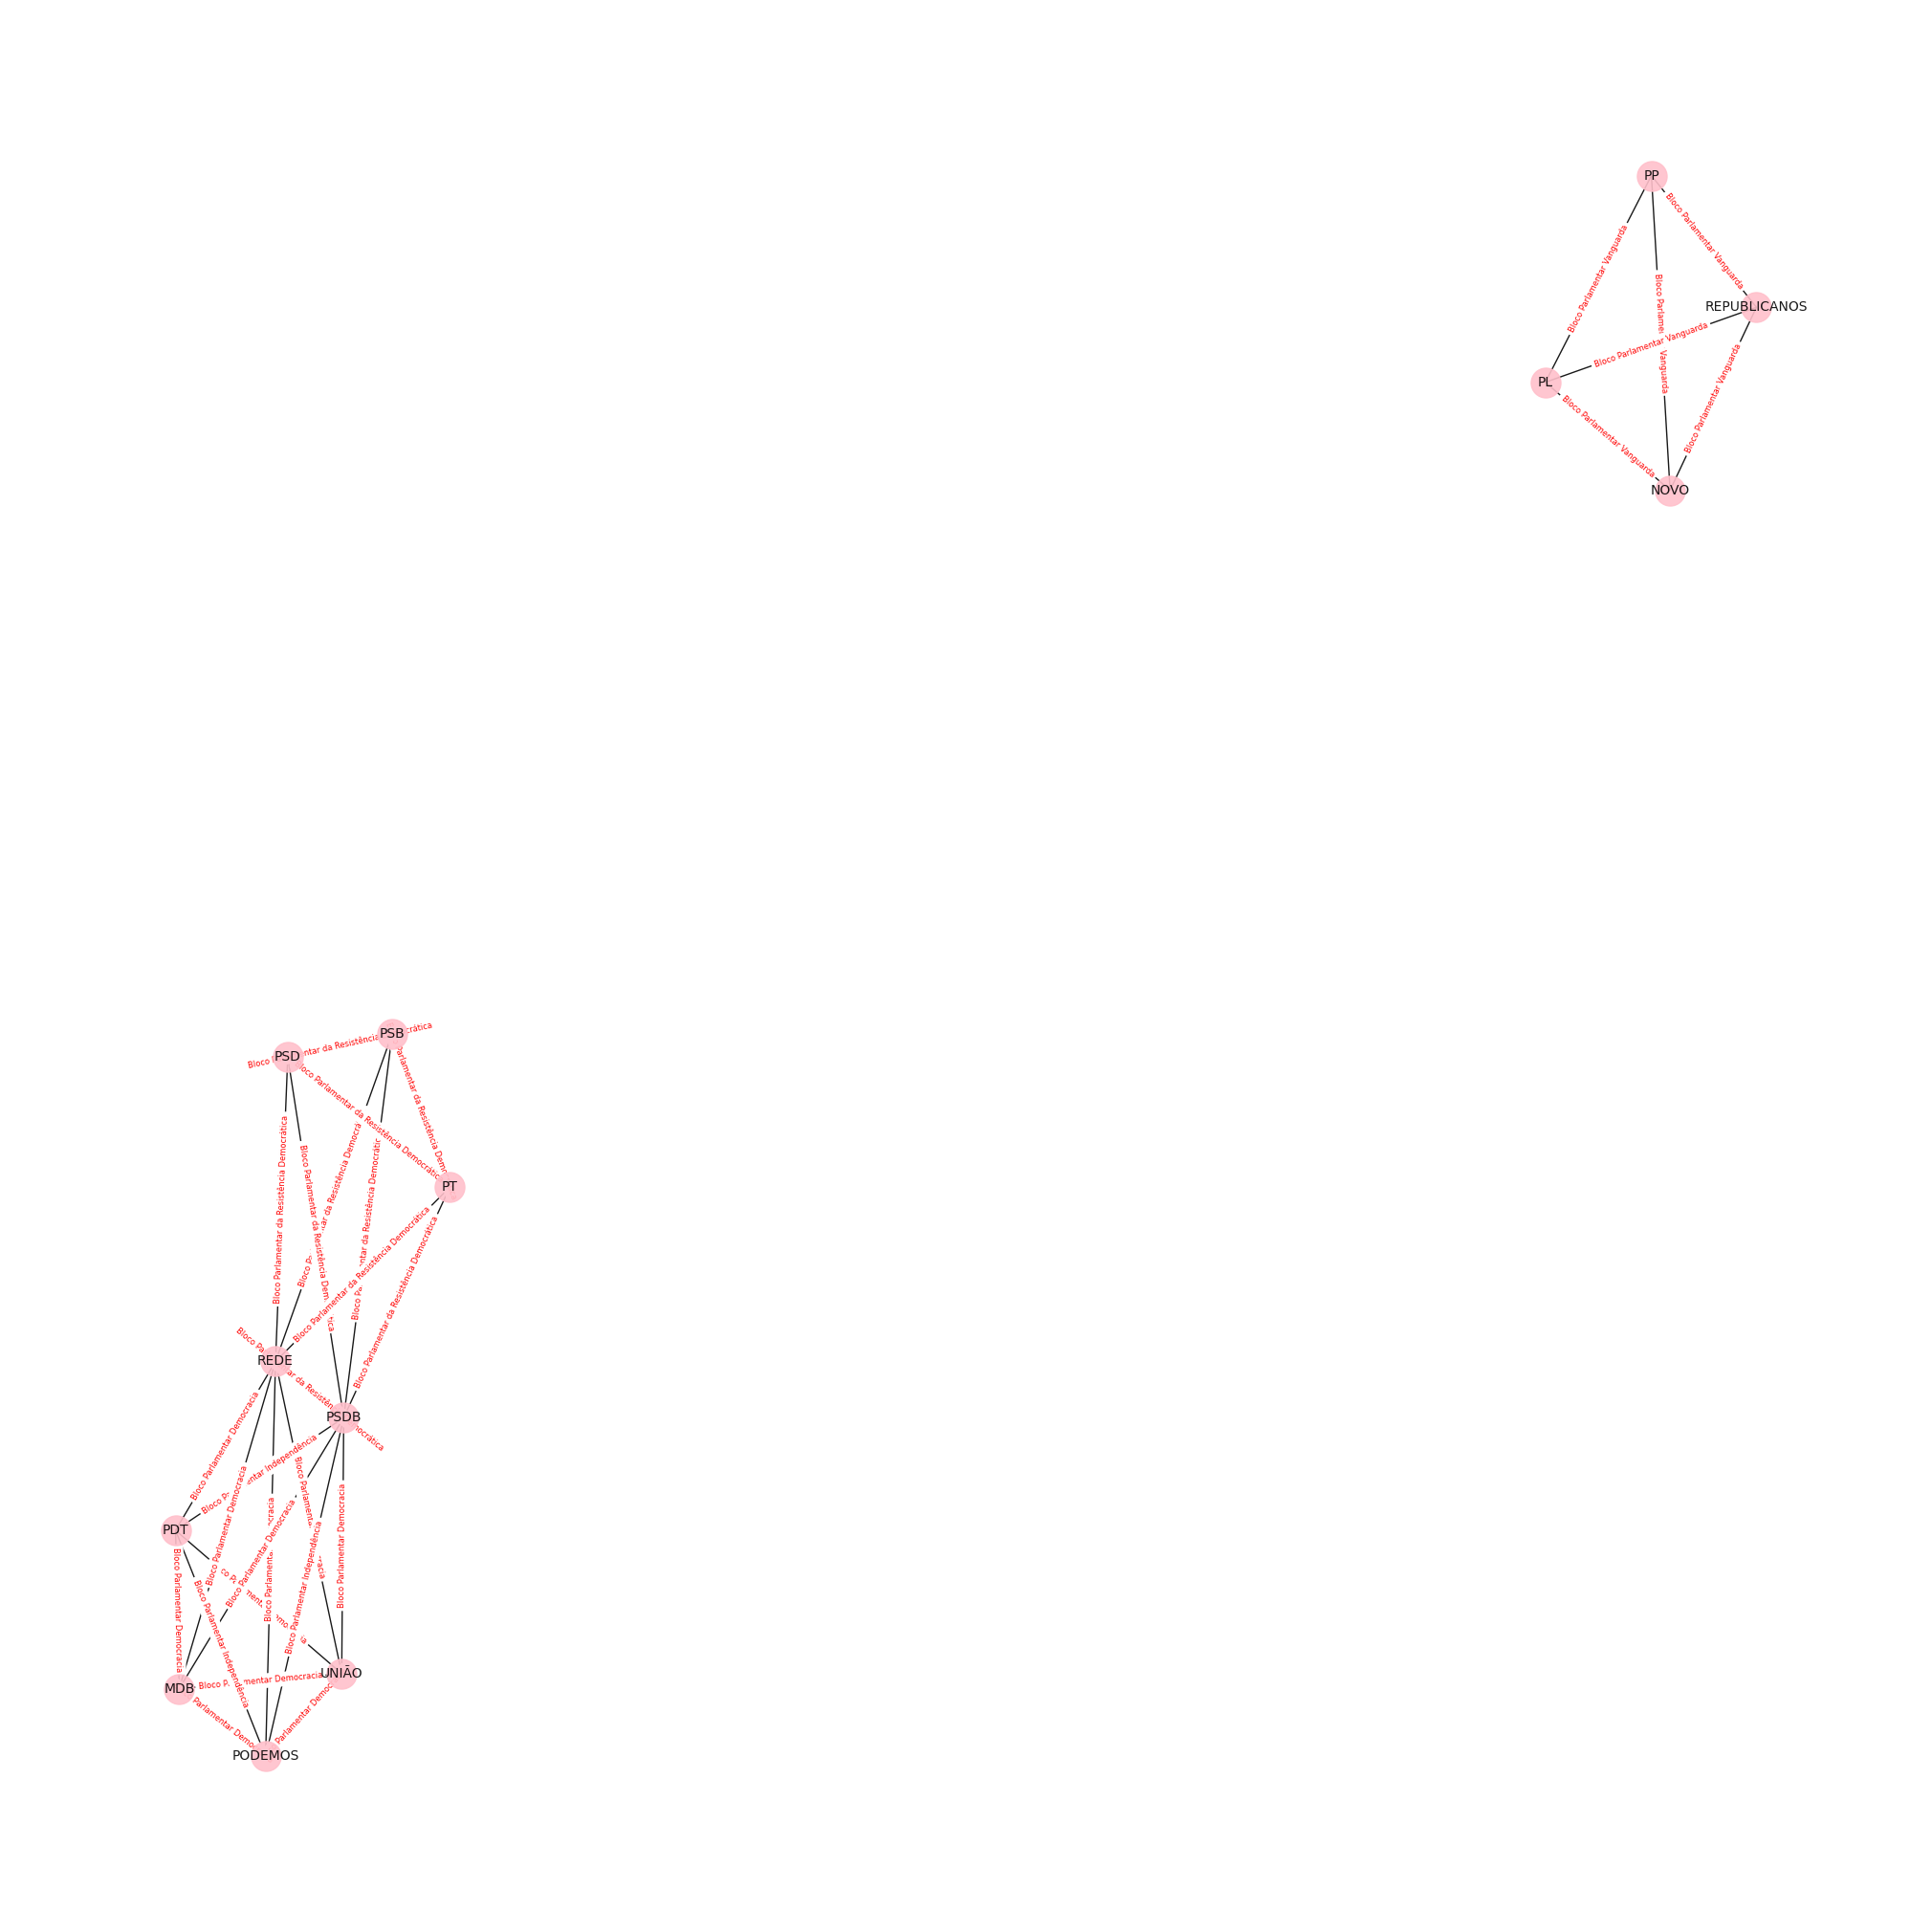

In [70]:
G.add_edges_from(edges)
pos = nx.spring_layout(G, k=0.3, scale=1,center=(0,0))
plt.figure(figsize=(20, 20))
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}, font_size=10
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edges_labels,
    font_color='red',
    font_size=6
)
plt.axis('off')
plt.show()

In [66]:
api_response_votacao = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/plenario/votacao/nominal/2024")
parsed_response_votacao = ApiXmlParser.parse(api_response_votacao.content, 'ISO-8859-1')
votacoes = parsed_response_votacao['ListaVotacoes']['Votacoes']['Votacao']

In [67]:
df_senadores_copy = df_senadores_joined.copy()
df_senadores_copy['Votos'] = 0
# df_senadores_copy
total_sessaos = 0
for sessao in votacoes:
    total_sessaos += 1
    if sessao.get('Votos', None):
        for voto in sessao['Votos']['VotoParlamentar']:
            df_senadores_copy.loc[voto['CodigoParlamentar'], 'Votos'] += 1
df_senadores_copy['PorcentagemVotos'] = df_senadores_copy['Votos'] / total_sessaos * 100
df_senadores_copy
                

,FormaTratamento_senadores,NomeParlamentar_senadores,SiglaPartido,Mandato,Afastamento,FormaTratamento_autores,NomeParlamentar_autores,QuantidadeMaterias,Votos,PorcentagemVotos
CodigoParlamentar,,,,,,,,,,
5672,Senador,Alan Rick,UNIÃO,2,0,Senador,Alan Rick,130,84,100.000000
5982,Senador,Alessandro Vieira,MDB,1,0,Senador,Alessandro Vieira,327,84,100.000000
6358,Senadora,Ana Paula Lobato,PDT,2,0,NaN,Ana Paula Lobato,2,82,97.619048
6358,Senadora,Ana Paula Lobato,PDT,2,0,Senadora,Ana Paula Lobato,51,82,97.619048
5967,Senador,Angelo Coronel,PSD,1,0,Senador,Angelo Coronel,192,84,100.000000
...,...,...,...,...,...,...,...,...,...,...
5971,Senador,Prisco Bezerra,PDT,1,1,Senador,Prisco Bezerra,11,0,0.000000
5913,Senador,Rafael Tenório,MDB,1,1,Senador,Rafael Tenório,2,0,0.000000
5892,Senador,Roberth Bringel,UNIÃO,1,1,Senador,Roberth Bringel,3,0,0.000000


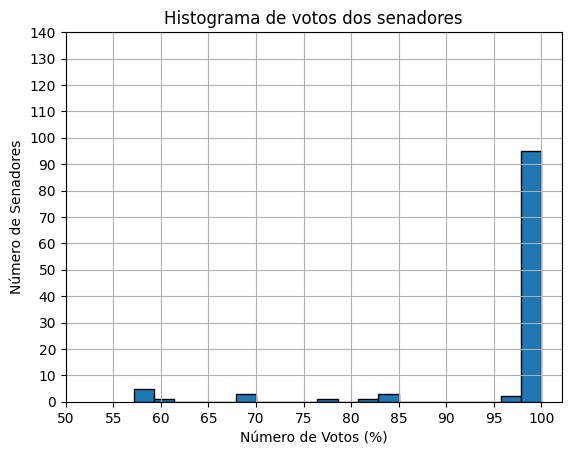

In [68]:
#histograma de votos
df_senadores_copy_atuais = df_senadores_copy[df_senadores_copy['Afastamento'] == '0']
df_senadores_copy_atuais['PorcentagemVotos'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Histograma de votos dos senadores')
plt.xlabel('Número de Votos (%)')
plt.ylabel('Número de Senadores')
plt.yticks(range(0, 150, 10))
plt.xticks(range(50, 105, 5))
plt.grid(True)
plt.show()

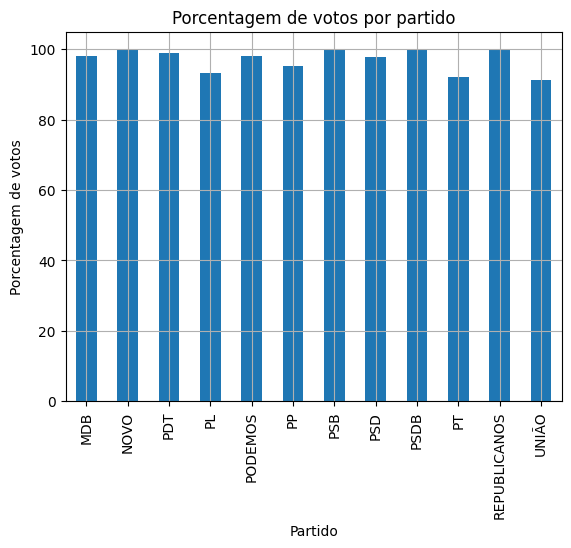

In [69]:
#histograma porcentagem por partido
df_senadores_copy_atuais.groupby('SiglaPartido')['PorcentagemVotos'].mean().plot(kind='bar')
plt.title('Porcentagem de votos por partido')
plt.xlabel('Partido')
plt.ylabel('Porcentagem de votos')
plt.grid(True)
plt.show()